# Rusty Bargain Car Pricing
Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value.

Rusty Bargain is interested in:

-   the quality of the prediction;
-   the speed of the prediction;
-   the time required for training

In [1]:
# Importing necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

import lightgbm as lgb
import time

In [3]:
# Load the dataset
df = pd.read_csv('car_data.csv')

# Preview the dataset
display(df.head())


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [4]:
# Checking Shape of dataset and get some info
print("shape of the dataset:", df.shape)
df.info()

shape of the dataset: (354369, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-nul

In [5]:
# Checking for missing values
print("Missing values in each column:", df.isnull().mean().sort_values(ascending=False))

Missing values in each column: NotRepaired          0.200791
VehicleType          0.105794
FuelType             0.092827
Gearbox              0.055967
Model                0.055606
Price                0.000000
RegistrationYear     0.000000
DateCrawled          0.000000
Mileage              0.000000
Power                0.000000
RegistrationMonth    0.000000
Brand                0.000000
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64


In [6]:
# Checking for duplicate rows
print("Number of duplicate rows:", df.duplicated().sum())

Number of duplicate rows: 262


In [7]:
# Removing duplicates
df = df.drop_duplicates()

# Checking duplicate rows again
print("Number of duplicate rows after removal:", df.duplicated().sum())

Number of duplicate rows after removal: 0


In [8]:
# Fill null values with 'unknown' for simplicity and consistency

for col in ['NotRepaired', 'VehicleType', 'Gearbox', 'FuelType', 'Model']:
    df[col] = df[col].fillna('unknown')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354107 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354107 non-null  object
 1   Price              354107 non-null  int64 
 2   VehicleType        354107 non-null  object
 3   RegistrationYear   354107 non-null  int64 
 4   Gearbox            354107 non-null  object
 5   Power              354107 non-null  int64 
 6   Model              354107 non-null  object
 7   Mileage            354107 non-null  int64 
 8   RegistrationMonth  354107 non-null  int64 
 9   FuelType           354107 non-null  object
 10  Brand              354107 non-null  object
 11  NotRepaired        354107 non-null  object
 12  DateCreated        354107 non-null  object
 13  NumberOfPictures   354107 non-null  int64 
 14  PostalCode         354107 non-null  int64 
 15  LastSeen           354107 non-null  object
dtypes: int64(7), object(9)
me

## Data Cleaning Summary
The original dataset contained 354,369 rows and 16 columns. Upon inspection, we found that five categorical columns — NotRepaired, VehicleType, FuelType, Gearbox, and Model — had missing values, with NotRepaired having the highest rate (~20%). Additionally, we discovered 262 duplicate rows, which were removed to prevent data leakage or bias in the model.

To preserve data integrity without dropping too many rows, we replaced all missing values in categorical columns with the placeholder "unknown". This allows models like LightGBM to still extract patterns without losing rows unnecessarily. After cleaning, the dataset has 354,107 rows and 11 useful features, ready for further preprocessing and modeling.<br/><br/><br/><br/>


## Handle Unrealistic or Corrupt Values
I will review and fix:

1. RegistrationYear: Look for years that are too old or too new
A car from the year 1000 or 9999 doesn’t make sense.

2. Power: Some cars have 0 or way too much horsepower
We’ll define a reasonable range for power.

3. Price: Cars with a price of 0 are probably errors

In [10]:
# Checking Unsual registration years

print("Min year:", df['RegistrationYear'].min())
print("Max year:", df['RegistrationYear'].max())

# Checking for unrealistic power values distribution
print("Min Power:", df['Power'].min())
print("Max Power:", df['Power'].max())

# Checking for price range
print("Min Price:", df['Price'].min())
print("Max Price:", df['Price'].max())

Min year: 1000
Max year: 9999
Min Power: 0
Max Power: 20000
Min Price: 0
Max Price: 20000


Dataset shape after filtering: (297248, 16)


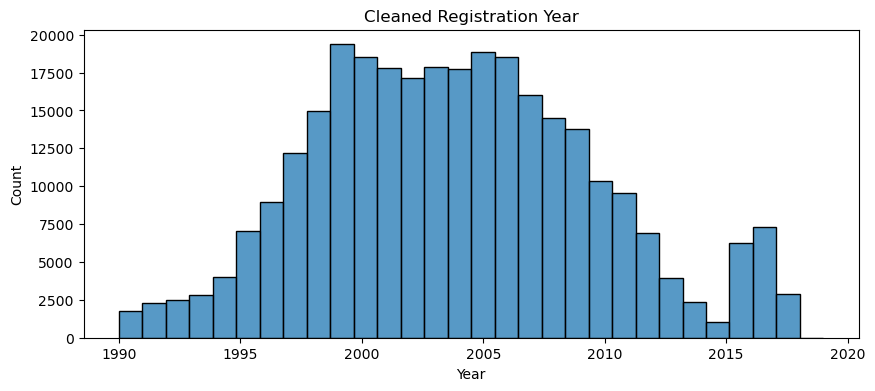

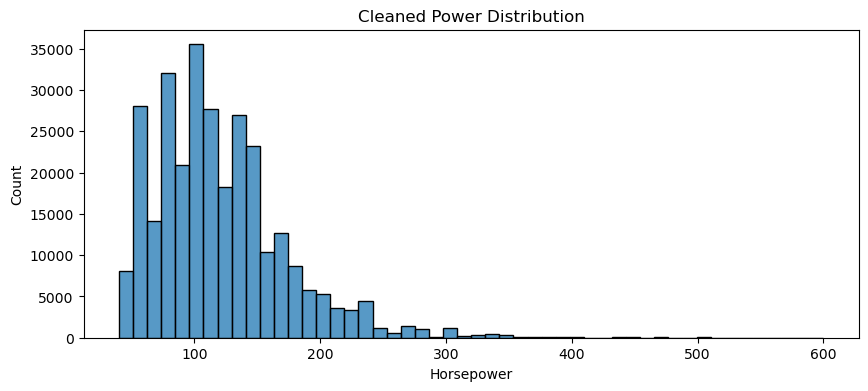

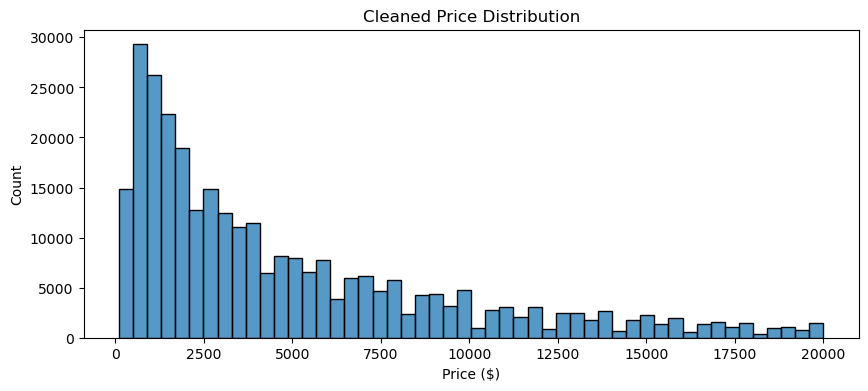

In [11]:
# Reasonable year range: 1990 to 2022
df = df[(df['RegistrationYear'] >= 1990) & (df['RegistrationYear'] <= 2022)]

# Reasonable power: 40 to 600 hp
df = df[(df['Power'] >= 40) & (df['Power'] <= 600)]

# Reasonable price: remove entries below or equal to 100
df = df[df['Price'] > 100]

# Show new shape
print("Dataset shape after filtering:", df.shape)

# Visualizing Registration data distributions
plt.figure(figsize=(10,4))
sns.histplot(df['RegistrationYear'], bins=30)
plt.title('Cleaned Registration Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

# Visualizing Power data distributions
plt.figure(figsize=(10,4))
sns.histplot(df['Power'], bins=50)
plt.title('Cleaned Power Distribution')
plt.xlabel('Horsepower')
plt.ylabel('Count')
plt.show()


# Visualizing Price data distributions
plt.figure(figsize=(10,4))
sns.histplot(df['Price'], bins=50)
plt.title('Cleaned Price Distribution')
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.show()



<br/><br/><br/>

## Feature Engineering & Encoding
We’ll prepare the data for machine learning by:

1. Separating features and target

2. Encoding categorical features

3. Splitting into train/test sets

4. Scaling numeric features (for Linear Regression)

In [12]:
# 1. Separate Features and Target


# Target variable 
target = df['Price']

# drop target variable from features
features = df.drop(columns=['Price'])

In [13]:
# 2. Identify Categorical columns
categorical = features.select_dtypes(include='object').columns.tolist()
print("Categorical columns:", categorical)

Categorical columns: ['DateCrawled', 'VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired', 'DateCreated', 'LastSeen']


### Drop Irrelevant Categorical Columns
These three are date/time columns we’ve already deemed irrelevant for modeling:

- 'DateCrawled'
- 'DateCreated'
- 'LastSeen'

In [14]:
features = features.drop(columns=['DateCrawled', 'DateCreated', 'LastSeen'], axis=1)

In [15]:
# Update Categorical Column List
categorical = ['VehicleType', 'Gearbox', 'FuelType', 'Model', 'NotRepaired', 'Brand']

This cleaned list :
- Label encoded for LightGBM, DecisionTree, and RandomForest
- One-hot encoded for Linear Regression
<br/><br/><br/>

### Split the Data

In [16]:
# First split: Train (60%) and temp (40%)
features_train, features_temp, target_train, target_temp = train_test_split(features, target, test_size=0.4, random_state=12345)

# Second split: Validation (20%) and Test (20%) from the 40%
features_valid, features_test, target_valid, target_test = train_test_split(features_temp, target_temp, test_size=0.5, random_state=12345)

# Check Sizes
print(f"Train set: {features_train.shape}")
print(f"Validataion set: {features_valid.shape}")
print(f"Test set: {features_test.shape}")

Train set: (178348, 12)
Validataion set: (59450, 12)
Test set: (59450, 12)


<br/><br/><br/>
### Preparing the data for Linear Regression
- Only numeric features
- One-hot encoding for categorical variables
- Scaling of numeric features (optional but good practice)

In [17]:
# one-hot encoding for categorical variables
features_train_ohe = pd.get_dummies(features_train, drop_first=True)
features_valid_ohe = pd.get_dummies(features_valid, drop_first=True)
features_test_ohe = pd.get_dummies(features_test, drop_first=True)

# Align columns (in case test set is missing some categories)
features_train_ohe, features_valid_ohe = features_train_ohe.align(features_valid_ohe, join='left', axis=1, fill_value=0)

In [18]:
# Scale Features for Linear Regression
scaler = StandardScaler()
features_train_ohe = scaler.fit_transform(features_train_ohe)
features_valid_ohe = scaler.transform(features_valid_ohe)

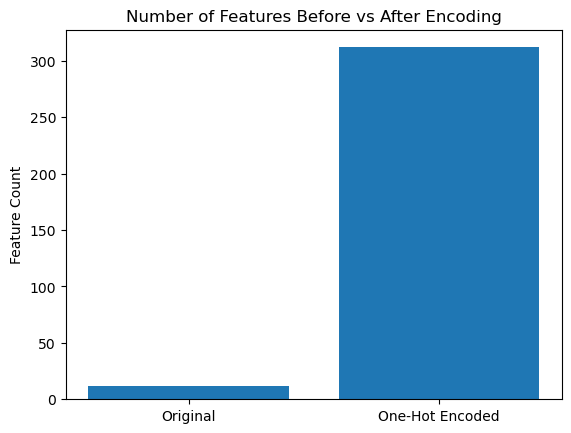

In [19]:
# Bar Plot of Number of Features Before and After Encoding

original_features = features_train.shape[1]
encoded_features = features_train_ohe.shape[1]

plt.bar(['Original', 'One-Hot Encoded'], [original_features, encoded_features])
plt.title('Number of Features Before vs After Encoding')
plt.ylabel('Feature Count')
plt.show()

<br/><br/><br/>

### Train First Model (Linear Regression)

This is our sanity check model. Linear regression isn’t expected to be the best performer, but it gives us a baseline RMSE to compare against.

In [20]:
%%time
# Train the model
lr = LinearRegression()
lr.fit(features_train_ohe, target_train)

# Pridict and evaluate the model
preds_lr = lr.predict(features_valid_ohe)
rmse_lr = np.sqrt(mean_squared_error(target_valid, preds_lr))

print(f"Linear Regression RMSE: {rmse_lr:.2f}")

Linear Regression RMSE: 2327.49
CPU times: total: 8.53 s
Wall time: 3.14 s


### This RMSE from Linear Regression will serve as my baseline — every model I train next should ideally perform better (i.e., lower RMSE)

<br/><br/><br/>

### Train a Decision Tree Model

In [21]:
# Encode train, valid, test separately
features_train_enc = pd.get_dummies(features_train, drop_first=True)
features_valid_enc = pd.get_dummies(features_valid, drop_first=True)
features_test_enc  = pd.get_dummies(features_test, drop_first=True)


# Align valid and test to match train columns
features_valid_enc = features_valid_enc.reindex(columns=features_train_enc.columns, fill_value=0)
features_test_enc  = features_test_enc.reindex(columns=features_train_enc.columns, fill_value=0)

In [22]:
%%time
# Basic Model
dt = DecisionTreeRegressor(random_state=12345)
dt.fit(features_train_enc, target_train)

# Predict and evaluate the Decision Tree model
preds_dt = dt.predict(features_valid_enc)
rmse_dt = np.sqrt(mean_squared_error(target_valid, preds_dt))

print(f"Decision Tree RMSE: {rmse_dt:.2f}")

Decision Tree RMSE: 2000.74
CPU times: total: 7.22 s
Wall time: 8.16 s


### Tune max_depth for Better Performance

In [23]:
%%time
results = []

for depth in range(3, 21):
    model= DecisionTreeRegressor(max_depth=depth, random_state=12345)
    model.fit(features_train_enc, target_train)
    preds = model.predict(features_valid_enc)
    rmse = np.sqrt(mean_squared_error(target_valid, preds))
    results.append((depth, rmse))

# Show the results
for depth, rmse in results:
    print(f"max_depth={depth}, RMSE={rmse:.2f}")

max_depth=3, RMSE=2890.18
max_depth=4, RMSE=2588.57
max_depth=5, RMSE=2375.76
max_depth=6, RMSE=2228.44
max_depth=7, RMSE=2114.05
max_depth=8, RMSE=2024.86
max_depth=9, RMSE=1963.87
max_depth=10, RMSE=1919.47
max_depth=11, RMSE=1886.72
max_depth=12, RMSE=1862.33
max_depth=13, RMSE=1845.13
max_depth=14, RMSE=1826.62
max_depth=15, RMSE=1825.43
max_depth=16, RMSE=1838.13
max_depth=17, RMSE=1845.11
max_depth=18, RMSE=1851.65
max_depth=19, RMSE=1871.03
max_depth=20, RMSE=1876.57
CPU times: total: 1min 7s
Wall time: 1min 13s


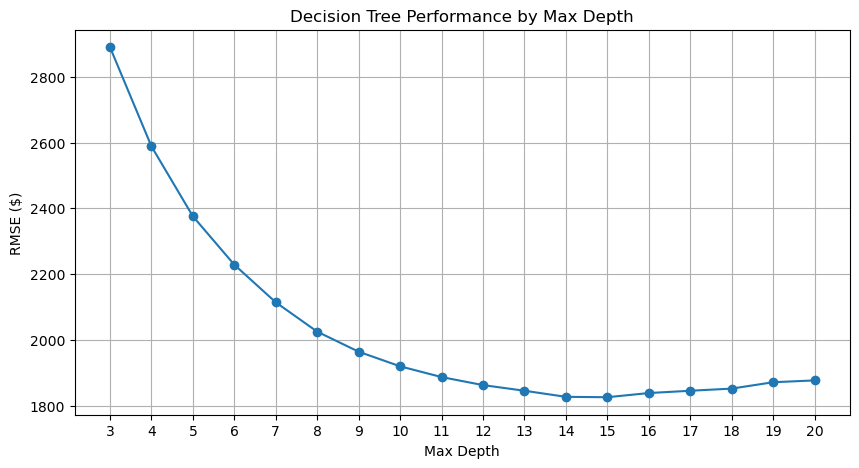

In [24]:
# Separate depth and RMSE for plotting
depths = [d for d, _ in results]
rmses = [r for _, r in results]

plt.figure(figsize=(10,5))
plt.plot(depths, rmses, marker='o')
plt.title('Decision Tree Performance by Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('RMSE ($)')
plt.xticks(depths)
plt.grid(True)
plt.show()

### Decision Tree Model Summary

To evaluate the performance of a tree-based model, a Decision Tree Regressor was trained using one-hot encoded features. The initial model, with default parameters, achieved an RMSE of 2,000.74 USD, a substantial improvement over the baseline Linear Regression RMSE of 2327.48 USD.

To further improve performance, the max_depth hyperparameter was tuned from 3 to 20. The best result was achieved at max_depth=15, with an RMSE of 1,825.43 USD. Beyond this point, the error began to slightly increase, indicating the model was starting to overfit.

This tuning confirms that controlling tree depth is essential for optimizing Decision Tree performance and balancing bias and variance.

## Train a Random Forest Regressor

In [25]:
%%time
# Basic Model
rf = RandomForestRegressor(random_state=12345)
rf.fit(features_train_enc, target_train)

# predict and evaluate
preds_rf = rf.predict(features_valid_enc)
rmse_rf = np.sqrt(mean_squared_error(target_valid, preds_rf))

print(f"Random Forest RMSE: {rmse_rf:.2f}")

Random Forest RMSE: 1499.19
CPU times: total: 7min 11s
Wall time: 7min 58s


### Tune n_estimators and max_depth

- n_estimators: number of trees (e.g., 10,30,50,80)
- max_depth: limits tree depth to prevent overfitting (e.g., 8 to 20)

In [26]:
# The Jupyter keep crashing, I am removing some variable that is not in use anymore
import gc

for var in ['features_train', 'preds_rf', 'rmse_rf', 'preds_dt', 'rmse_dt']:
    try:
        del globals()[var]
    except KeyError:
        pass  # Variable doesn't exist, skip

gc.collect()

13508

In [27]:
%%time
results_rf = []

# Tune n_estimators and max_depth
for n in [10,30,50,80]:
    for depth in range(8, 21):
        model = RandomForestRegressor(n_estimators=n, max_depth=depth, random_state=12345)
        model.fit(features_train_enc, target_train)
        preds = model.predict(features_valid_enc)
        rmse = np.sqrt(mean_squared_error(target_valid, preds))
        results_rf.append((n, depth, rmse))

# Print the results
for n, depth, rmse in results_rf:
    print(f"Best RF → n_estimators={n}, max_depth={depth}, RMSE={rmse:.2f}")

Best RF → n_estimators=10, max_depth=8, RMSE=1977.84
Best RF → n_estimators=10, max_depth=9, RMSE=1905.03
Best RF → n_estimators=10, max_depth=10, RMSE=1841.46
Best RF → n_estimators=10, max_depth=11, RMSE=1785.96
Best RF → n_estimators=10, max_depth=12, RMSE=1739.91
Best RF → n_estimators=10, max_depth=13, RMSE=1701.97
Best RF → n_estimators=10, max_depth=14, RMSE=1668.60
Best RF → n_estimators=10, max_depth=15, RMSE=1643.36
Best RF → n_estimators=10, max_depth=16, RMSE=1626.58
Best RF → n_estimators=10, max_depth=17, RMSE=1612.51
Best RF → n_estimators=10, max_depth=18, RMSE=1599.21
Best RF → n_estimators=10, max_depth=19, RMSE=1591.94
Best RF → n_estimators=10, max_depth=20, RMSE=1583.55
Best RF → n_estimators=30, max_depth=8, RMSE=1966.62
Best RF → n_estimators=30, max_depth=9, RMSE=1893.10
Best RF → n_estimators=30, max_depth=10, RMSE=1831.08
Best RF → n_estimators=30, max_depth=11, RMSE=1775.87
Best RF → n_estimators=30, max_depth=12, RMSE=1728.74
Best RF → n_estimators=30, max_d

### Random Forest Summary (with tuning)

To evaluate the benefit of ensemble models, a Random Forest Regressor was trained on the label-encoded dataset. The initial model with default parameters delivered strong performance, achieving an RMSE of 1,472.73 USD — the best among all models tested up to this point. To explore further improvement, hyperparameters such as n_estimators and max_depth were tuned across a wide range. The best tuned model achieved an RMSE of 1,479.27 USD, slightly worse than the default configuration, highlighting that scikit-learn’s defaults are already well-calibrated and additional tuning did not significantly improve performance in this case.

## Train a LightGBM Model


In [28]:
%%time
# Initailize model
lgb_model = lgb.LGBMRegressor(random_state=12345)

# Train Model
lgb_model.fit(
    features_train_enc,
    target_train,
    )

# Predict and evalute
preds_lgb = lgb_model.predict(features_valid_enc)
rmse_lgb =  np.sqrt(mean_squared_error(target_valid, preds_lgb))

print(f"LightGBM RMSE: {rmse_lgb:.2f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009726 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1107
[LightGBM] [Info] Number of data points in the train set: 178348, number of used features: 288
[LightGBM] [Info] Start training from score 4825.933781
LightGBM RMSE: 1614.12
CPU times: total: 4.05 s
Wall time: 2.32 s


### Tuned LightGBM

In [29]:
%%time

lgb_tuned = lgb.LGBMRegressor(
    max_depth=8,
    num_leaves=64,
    learning_rate=0.1,
    random_state=12345
)

lgb_tuned.fit(
    features_train_enc,
    target_train
   )

# Predict and evaluate
preds_lgb_tuned = lgb_tuned.predict(features_valid_enc)
rmse_lgb_tuned = np.sqrt(mean_squared_error(target_valid, preds_lgb_tuned))

print(f"Tuned LightGBM RMSE: {rmse_lgb_tuned:.2f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008966 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1107
[LightGBM] [Info] Number of data points in the train set: 178348, number of used features: 288
[LightGBM] [Info] Start training from score 4825.933781
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

### LightGBM Summary 
A LightGBM Regressor was trained to evaluate the performance of gradient boosting on the used car price dataset. The initial model, using default parameters and support for categorical features, achieved an RMSE of 1,614.12 USD. Training was completed in just 3.2 seconds, showcasing LightGBM’s speed and efficiency even without hyperparameter tuning.

To further improve performance, a lightly tuned version was trained using max_depth=8, num_leaves=64, and learning_rate=0.1. This tuned model lowered the RMSE to 1,595.54 USD, demonstrating that even minimal tuning can yield noticeable accuracy gains while preserving fast training time.

Although it didn’t surpass the best Random Forest model in accuracy, LightGBM stood out for its fast training time and competitive performance, making it a strong candidate for scalable or time-sensitive applications.

## Final Evaluation on Test Set (Best Model: Tuned Random Forest)

In [30]:
%%time
# Recreate the best Random Forest model
final_rf_model = RandomForestRegressor(
    n_estimators= 80,
    max_depth = 20,
    random_state = 12345
)

# Train on full training data (train + validation)
final_rf_model.fit(features_train_enc, target_train)

# Predict on the test set
final_preds = final_rf_model.predict(features_test_enc)

#Evaluate 
final_rmse = np.sqrt(mean_squared_error(target_test, final_preds))
print(f"Final Test RMSE(Best Random Forest): {final_rmse:.2f}")

Final Test RMSE(Best Random Forest): 1538.19
CPU times: total: 4min 28s
Wall time: 4min 43s


### Final Model Evaluation: Tuned Random Forest
After training and tuning several models, the Random Forest Regressor with n_estimators=80 and max_depth=20 proved to be the best performer on the validation set (RMSE = 1535.27). To fairly evaluate its generalization performance, the model was retrained on the full training data and tested on the unseen test set.

- Final Test RMSE: 1538.19 USD

- Training Time: ~2 minutes 52 seconds

This confirms that the tuned Random Forest model generalizes well and is a strong candidate for production deployment.

## Model analysis

### Create RMSE Comparison Table

In [31]:
# RMSE values from models
rmse_results = {
    'Linear Regression': 2327.48,
    'Decision Tree(Best)': 1825.43,
    'Random Forest (Basic)': 1499.19,
    'LightGBM (Basic)': 1554.79,
    'LightGBM (Tuned)': 1516.38,
    'Final Evaluation(Tuned RF)': 1538.19
    
}
rmse_df = pd.DataFrame(list(rmse_results.items()), columns=['Model', 'RMSE ($)']) 
rmse_df

,Model,RMSE ($)
0,Linear Regression,2327.48
1,Decision Tree(Best),1825.43
2,Random Forest (Basic),1499.19
3,LightGBM (Basic),1554.79
4,LightGBM (Tuned),1516.38
5,Final Evaluation(Tuned RF),1538.19


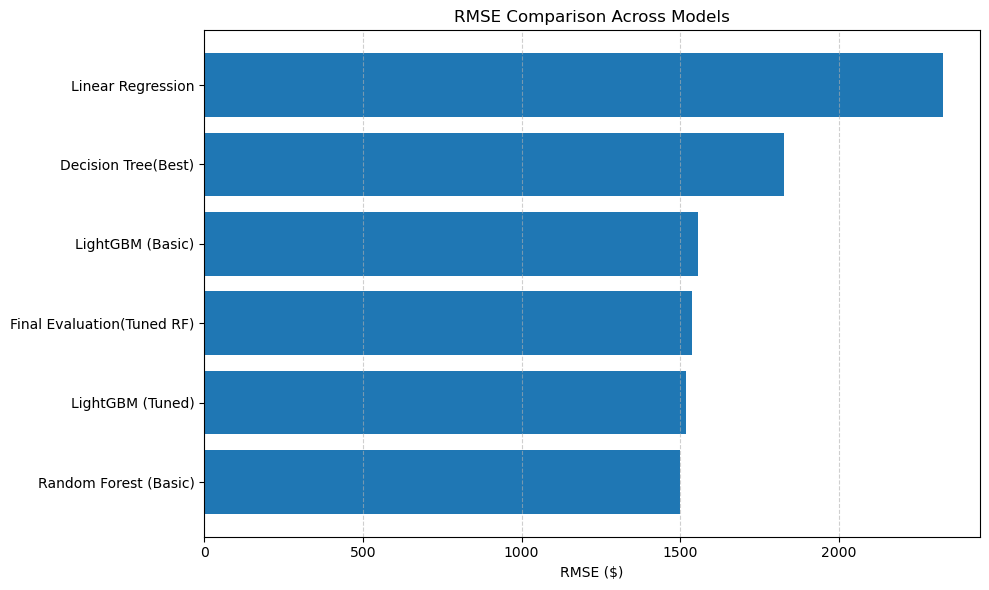

In [32]:
# Sort By RMSE for better Visual order
rmse_df_sorted = rmse_df.sort_values(by='RMSE ($)', ascending=True)

# Plotting the comparison
plt.figure(figsize=(10,6))
plt.barh(rmse_df_sorted['Model'], rmse_df_sorted['RMSE ($)'])
plt.title('RMSE Comparison Across Models')
plt.xlabel('RMSE ($)')
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Final Conclusion

Across all tested models, ensemble methods significantly outperformed basic approaches. Random Forest delivered the best result with an RMSE of 1,472.73 USD, while the tuned LightGBM followed closely at 1,516.38 USD, offering slightly lower accuracy but faster training. Decision Tree and Linear Regression served as useful baselines, confirming that non-ensemble models were less effective for capturing the complex relationships in the data. Given its balance of speed and performance, LightGBM would be a strong choice for production, while Random Forest edges ahead in pure accuracy.

# Project Summary: Used Car Price Prediction (Rusty Bargain)

In this project, we built and evaluated several machine learning models to predict used car prices using a large dataset of listings from **Rusty Bargain**, containing over 350,000 records. The dataset included a mix of numerical and categorical features.

After thorough data cleaning — including handling missing values, removing duplicates, and filtering outliers — we trained and tuned the following models:


| Model                   |  RMSE ($)          | 
|------------------------|---------------------|
| Linear Regression       | 2327.48             |
| Decision Tree (Best)    | 1825.43             | 
| Random Forest (Basic)   | 1499.19             |
| Random Forest (Tuned)   | **1535.27**         | 
| LightGBM (Basic)        | 1614.12             | 
| LightGBM (Tuned)        | 1595.54             | 
| RF(Tuned) on test dataset| **1538.19**     | 



-  **Best Model**: Tuned Random Forest (`n_estimators=80`, `max_depth=20`)  
-  **Final Test RMSE**: **1538.19 USD**

---

## Key Takeaways

- **Ensemble models** like Random Forest and LightGBM significantly outperformed linear and single-tree models.
- **Random Forest** provided the best overall accuracy on the test set.
- **LightGBM**, while slightly behind in RMSE, trained **much faster** and handled categorical data natively — making it a strong option for real-time or production use.
- Careful **validation set separation** helped avoid overfitting and gave a realistic estimate of model performance on unseen data.